In [1]:
from fractions import Fraction
import numpy as np
import matplotlib.pyplot as plt

def Abashcoefficients(order: int)->list:
    '''
    Hàm trả về hệ số của công thức Adams Bashforth
    :param order: bậc của công thức
    :return: list chứa các hệ số ở dạng phân số
    '''
    A = np.zeros((order, order))
    c = np.ones(order)
    for i in range(order):
        for j in range(order):
            A[i, j] = (j) ** i
        c[i] = Fraction((-1) ** i, i + 1)
    Adamsbashcoefficients = np.linalg.inv(A).dot(c)
    return [str(Fraction(x).limit_denominator()) for x in Adamsbashcoefficients]

def Amoultoncoefficients(order: int)-> list:
    '''
    Hàm trả về hệ số của công thức Adams Moulton
    :param order: bậc của công thức
    :return: list chứa các hệ số ở dạng phân số
    '''
    A = np.zeros((order, order))
    c = np.ones(order)
    for i in range(order):
        for j in range(order):
            A[i, j] = (j - 1) ** i
        c[i] = Fraction((-1) ** i, i + 1)
    solution = np.linalg.inv(A).dot(c)
    AdamsMoultonmoultonCoefficients = [str(Fraction(x).limit_denominator()) for x in solution]
    return AdamsMoultonmoultonCoefficients

def rk4(t, y, h, f):
    '''
    Hàm tính giá trị của y tại điểm t+h bằng phương pháp RK4
    :param t: điểm hiện tại
    :param y: giá trị của y tại điểm hiện tại
    :param h: bước nhảy
    :param f: hàm f(t, y)'''
    k1 = h * f(t, y)
    k2 = h * f(t + h/2, y + k1/2)
    k3 = h * f(t + h/2, y + k2/2)
    k4 = h * f(t + h, y + k3)
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6
def creABAM(order: int):
    '''
    Hàm trả về mảng lưu các mảng lưu hệ số của phương pháp Adams Bashforth và Adams Moulton từ bậc 1 đến bậc order
    :param order: bậc của phương pháp
    :return: mảng lưu các mảng hệ số của phương pháp Adams Bashforth và Adams Moulton
    '''
    ab = []
    am = []
    for i in range(1, order+1):
        tmp = Abashcoefficients(i)
        ab.append([float(Fraction(x)) for x in tmp])
    for i in range(1, order+1):
        tmp = Amoultoncoefficients(i+1)
        am.append([float(Fraction(x)) for x in tmp])
    return ab, am

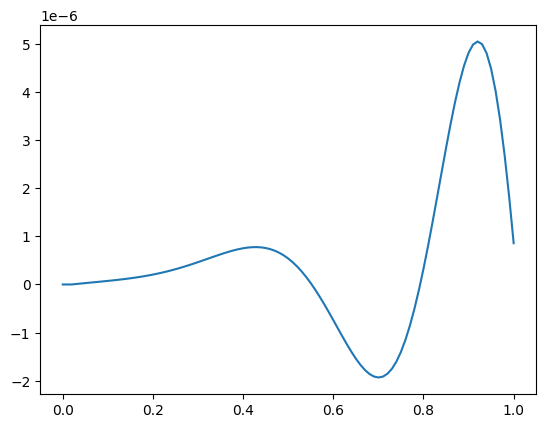

In [2]:
def initialize_arrays(num_steps, y_start, t_start, t_end):
    '''
    Hàm khởi tạo mảng chứa giá trị của y và t
    :param num_steps: số bước nhảy
    :param y_start: giá trị của y tại thời điểm ban đầu
    :param t_start: điểm ban đầu
    :param t_end: điểm kết thúc
    :return: bước nhảy h, mảng t, mảng giá trị y
    '''
    h = (t_end - t_start) / num_steps
    t = np.linspace(t_start, t_end, num_steps + 1)
    y = np.zeros((num_steps + 1, len(y_start)))
    y[0, :] = y_start
    return h, t, y
def compute_initial_values_lp(order, h, f, t, y, Adams_bashforth, Adams_moulton):
    '''
    Hàm tính giá trị của y tại các bước nhảy đầu tiên bằng phương pháp lưới phủ
    :param order: bậc của phương pháp
    :param h: bước nhảy
    :param f: vector f(t, y)
    :param t: mảng các điểm cần giải
    :param y: mảng giá trị y
    :param Adams_bashforth: mảng lưu các mảng lưu hệ số của phương pháp Adams Bashforth từ bậc 1 đến bậc order
    :param Adams_moulton: mảng lưu các mảng lưu hệ số của phương pháp Adams Moulton từ bậc 1 đến bậc order
    :return: mảng giá trị y sau khi tính toán
    '''
    for i in range(1, order):
        f_eval_pre = np.array([f(t[i-j], y[i-j, :]) for j in range(i)])
        y_pred = y[i-1, :] + h * np.dot(f_eval_pre.T, np.array(Adams_bashforth[i-1]))
        y[i, :] = y_pred
        f_eval_corr = np.array([f(t[i-j], y[i-j, :]) for j in range(i+1)])
        y_corr = y[i-1, :] + h * np.dot(f_eval_corr.T, np.array(Adams_moulton[i-1]))
        while (np.linalg.norm(y_corr - y_pred) >= 1e-9):
            y_pred = y_corr
            y_corr = y[i-1, :] + h * np.dot(f_eval_corr.T, np.array(Adams_moulton[i-1]))
        y[i, :] = y_corr
    return y
def compute_initial_steps_other(order, h, t, y, f):
    '''
    Hàm tính giá trị của y tại các bước nhảy đầu tiên bằng phương pháp RK4
    :param order: bậc của phương pháp
    :param h: bước nhảy
    :param f: vector f(t, y)
    :param t: mảng các điểm cần giải
    :param y: mảng giá trị y
    :return: mảng giá trị y sau khi tính toán
    '''
    for i in range(1, order):
        y[i] = rk4(t[i-1], y[i-1], h, f)
    return y

def compute_remaining_values_usingAB(order, num_steps, h, f, t, y, Adams_bashforth):
    '''
    Hàm tính giá trị của y tại các bước nhảy còn lại bằng phương pháp Adams Bashforth
    :param order: bậc của phương pháp
    :param num_steps: số bước nhảy
    :param h: bước nhảy
    :param f: vector f(t, y)
    :param t: mảng các điểm cần giải
    :param y: mảng giá trị y
    :param Adams_bashforth: mảng chứa các hệ số của Adams Bashforth bậc order
    :return: mảng giá trị y sau khi tính toán
    '''
    for i in range(order, num_steps+1):
        # Predictor step using Adams-Bashforth method
        y_pred = y[i-1] + h * np.dot(np.array([f(t[i-j], y[i-j]) for j in range(1, order+1)]).T, np.array(Adams_bashforth))
        y[i] = y_pred
    return y
def compute_remaining_values_usingAM(order, num_steps, h, f, t, y, Adams_moulton):
    '''
    Hàm tính giá trị của y tại các bước nhảy còn lại bằng phương pháp Adams Moulton
    :param order: bậc của phương pháp
    :param num_steps: số bước nhảy
    :param h: bước nhảy
    :param f: vector f(t, y)
    :param t: mảng các điểm cần giải
    :param y: mảng giá trị y
    :param Adams_moulton: mảng chứa các hệ số của Adams Moulton bậc order
    :return: mảng giá trị y sau khi tính toán
    '''
    def g(y_fixpoint, y, i, t, h, order, adams_moulton_coeffs):
        term = np.array([f(t[i-j], y[i-j]) for j in range(order+1)])
        return y[i-1] + h * np.dot(term.T, np.array(adams_moulton_coeffs))
    for i in range(order, num_steps+1):
        y_corr = y[i-1]
        y[i] = y_corr
        while True:
            y_new = g(y_corr, y, i, t, h, order, Adams_moulton)
            if np.linalg.norm(y_new - y_corr) < 1e-9:  # Convergence criterion
                break
            y_corr = y_new
        y[i] = y_corr
    return y
def compute_remaining_values_usingABAM(order, num_steps, h, f, t, y, Adams_bashforth, Adams_moulton):
    '''
    Hàm tính giá trị của y tại các bước nhảy còn lại bằng phương pháp Adams Bashforth Moulton
    :param order: bậc của phương pháp
    :param num_steps: số bước nhảy
    :param h: bước nhảy
    :param f: vector f(t, y)
    :param t: mảng các điểm cần giải
    :param y: mảng giá trị y
    :param Adams_bashforth: mảng chứa các hệ số của Adams Bashforth bậc order
    :param Adams_moulton: mảng chứa các hệ số của Adams Moulton bậc order
    :return: mảng giá trị y sau khi tính toán'''
    for i in range(order, num_steps+1):
        f_eval_pre = np.array([f(t[i-j], y[i-j, :]) for j in range(order)])
        y_pred = y[i-1, :] + h * np.dot(f_eval_pre.T, np.array(Adams_bashforth))
        y[i, :] = y_pred
        f_eval_corr = np.array([f(t[i-j], y[i-j, :]) for j in range(order+1)])
        y_corr = y[i-1, :] + h * np.dot(f_eval_corr.T, np.array(Adams_moulton))
        while (np.linalg.norm(y_corr - y_pred) >= 1e-9):
            y_pred = y_corr
            y_corr = y[i-1, :] + h * np.dot(f_eval_corr.T, np.array(Adams_moulton))
        y[i, :] = y_corr
    return y
def sol(order, num_steps, t_start, t_end, y_start, Adams_bashforth, Adams_moulton, f):
    '''
    Hàm giải hệ phương trình vi phân bằng phương pháp Adams Bashforth Moulton
    :param order: bậc của phương pháp
    :param num_steps: số bước nhảy
    :param t_start: điểm bắt đầu
    :param t_end: điểm kết thúc
    :param y_start: giá trị của y tại thời điểm ban đầu
    :param Adams_bashforth: mảng lưu các mảng lưu hệ số của phương pháp Adams Bashforth từ bậc 1 đến bậc order
    :param Adams_moulton: mảng lưu các mảng lưu hệ số của phương pháp Adams Moulton từ bậc 1 đến bậc order
    :param f: vector f(t, y)
    :return: mảng t, mảng y
    '''
    h, t, y = initialize_arrays(num_steps, y_start, t_start, t_end)
    # y = compute_initial_values_lp(order, h, f, t, y, Adams_bashforth, Adams_moulton)
    y = compute_initial_steps_other(order, h, t, y, f)
    y = compute_remaining_values_usingABAM(order, num_steps, h, f, t, y, Adams_bashforth[order-1], Adams_moulton[order-1])
    return t, y


# Define the system of ODEs as a function
def f(t, y):
    # Example system: dy1/dt = y2, dy2/dt = -y1 (Simple Harmonic Oscillator)
    y1 = y
    dy1_dt = -np.exp(-t)*(np.cos(8*t**2)+16*t*np.sin(8*t**2))
    return np.array([dy1_dt])

# Initial conditions
order = 3
num_steps = 100
t_start = 0.0
t_end = 1.0
y_start = np.array([1.0])

ab, am = creABAM(order)
def exactf(t):
    y1 = np.exp(-t)*np.cos(8*t**2)
    return np.array([y1])
# Solve the system
t, y = sol(order, num_steps, t_start, t_end, y_start, ab, am, f)
plt.plot(t, y-exactf(t).T)
# t contains the time points, and y contains the solution vectors at those time points


0.015625


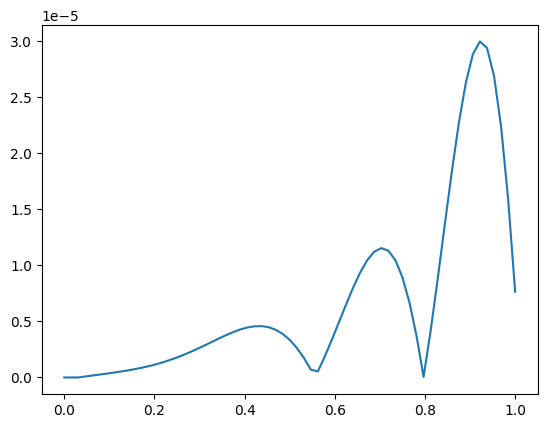

In [3]:
import math
def split_array(arr, n):
    '''
    Hàm chia mảng arr thành n phần bằng cách thêm phần tử ở giữa các phần tử liên tiếp
    :param arr: mảng cần chia
    :param n: số lần chia
    :return: mảng sau khi chia
    '''
    for _ in range(n):
        new_arr = []
        for i in range(len(arr) - 1):
            new_arr.append(arr[i])
            new_arr.append((arr[i] + arr[i+1]) // 2)
        new_arr.append(arr[-1])
        arr = new_arr
    return arr
def common_elements(arr1, arr2):
    '''
    Hàm trả về các phần tử chung của 2 mảng arr1 và arr2
    :param arr1: mảng 1
    :param arr2: mảng 2
    :return: mảng chứa các phần tử chung
    '''
    return list(set(arr1) & set(arr2))
def splits_and_common(arr, n):
    '''
    Hàm thực hiện việc chia mảng arr n lần và trả về các phần tử chung của mảng sau khi chia lần cuối cùng và mảng sau khi chia lần cuối cùng
    :param arr: mảng cần chia
    :param n: số lần chia
    :return: mảng chứa các phần tử chung
    '''
    # Perform the splits and find common elements
    for i in range(1, n+1):
        new_arr = split_array(arr, 1)
        if i==n:
            break
        arr = new_arr
    return common_elements(arr, new_arr)
def combinefinal(n_h, t_start, t_end):
    '''
    Hàm trả về mảng chứa các index của các điểm cần so sánh 
    :param n_h: số lần chia
    :param t_start: điểm bắt đầu
    :param t_end: điểm kết thúc
    :return: mảng chứa các index của các điểm cần so sánh'''
    h = 1/2**(2+n_h)
    # Start with an initial array
    arr = [0, math.floor((t_end - t_start) /h)]
    n = 2+n_h
    return splits_and_common(arr, n)

def f(t, y):
    y1 = y
    dy1_dt = -np.exp(-t)*(np.cos(8*t**2)+16*t*np.sin(8*t**2))
    return np.array([dy1_dt])
def sol_know_e(t_start, t_end, order, y_start, e, f):
    '''
    Hàm giải hệ phương trình vi phân bằng phương pháp Adams Bashforth Moulton với sai số e
    :param t_start: điểm bắt đầu
    :param t_end: điểm kết thúc
    :param order: bậc của phương pháp
    :param y_start: giá trị của y tại thời điểm ban đầu
    :param e: sai số
    :param f: vector f(t, y)
    :return: mảng t, mảng y
    '''
    h = 1/4
    n_h = 0
    # Start with an initial array
    arr = [0, math.floor((t_end - t_start) /h)]
    ab, am = creABAM(order)
    num_steps = math.floor((t_end - t_start) /h)
    t, y = sol(order, num_steps, t_start, t_end, y_start, ab, am,f)
    # print(y.shape)
    # print(combinefinal(n_h, t_start, t_end))
    while h>1e-5:
        y_pre = y
        h /=2
        num_steps = math.floor((t_end - t_start) /h)
        t, y = sol(order, num_steps, t_start, t_end, y_start, ab, am,f)
        y_last = y
        ss = np.array([abs(y_pre[i]-y_last[i*2]) for i in combinefinal(n_h, t_start, t_end)])
        n_h += 1
        # print(np.max(ss))
        #e*y_pre[np.argmax(ss)]
        if np.max(ss) < e:
            print(h)
            break
    return t, y
t, y = sol_know_e(0, 1, 3, np.array([1]), 1e-3, f)
plt.plot(t, abs(y-exactf(t).T), label = "error")

[0, 50, 100]